# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [42]:
# Add any additional import statements you need here
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/samantharivas/Documents/UNIVERSITY OF SAN DIEGO/ADS509/tokenization-normalization-and-descriptivestatistics/M1 Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data

# initialize empty dictionary to store the lyrics data
lyrics_data = {}

# iterate over each artist folder
for artist in os.listdir(data_location + lyrics_folder):
    artist_folder = os.path.join(data_location + lyrics_folder, artist)
    if os.path.isdir(artist_folder):  
        artist_lyrics = []
        for song_file in os.listdir(artist_folder):
            song_path = os.path.join(artist_folder, song_file)
            if os.path.isfile(song_path):  
                with open(song_path, 'r', encoding='utf-8') as file:
                    lyrics = file.read()
                    artist_lyrics.append({'artist': artist, 'song': song_file, 'lyrics': lyrics})
        # create df 
        artist_lyrics_df = pd.DataFrame(artist_lyrics)
        lyrics_data[artist] = artist_lyrics_df
    
# concatenate df for both artists
lyrics_data = pd.concat(lyrics_data.values(), ignore_index=True)

lyrics_data.sample(10)

,artist,song,lyrics
356,cher,cher_ifoundsomeone.txt,"""I Found Someone""\n\n\n\nDon't you know\nSo ma..."
181,cher,cher_youbettersitdownkids.txt,"""You Better Sit Down Kids""\n\n\n\nBetter sit d..."
406,cher,cher_wasntitgood.txt,"""Wasn't It Good""\n\n\n\nWasn't it good\nThe wa..."
187,cher,cher_themusicsnogoodwithoutyou.txt,"""The Music's No Good Without You""\n\n\n\nEvery..."
331,cher,cher_savethechildren.txt,"""Save The Children""\n\n\n\nDon't look over my ..."
343,cher,cher_saytheword.txt,"""Say The Word""\n\n\n\nThe moon hangs like the ..."
59,robyn,robyn_cobrastyle.txt,"""Cobrastyle""\n\n\n\nI press trigga, I don't pr..."
135,cher,cher_therebutforfortune.txt,"""There But For Fortune""\n\n\n\nShow me the pri..."
333,cher,cher_rudy.txt,"""Rudy""\n\n\n\nRudy toot, it's been a long time..."
286,cher,cher_yoursuntiltomorrow.txt,"""Yours Until Tomorrow""\n\n\n\nTonight I hold t..."


In [53]:
# Read in the twitter data
artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)
twitter_data['artist'] = "cher"

twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

# concatenate df for both artists
twitter_data = pd.concat([twitter_data,twitter_data_2])
del(twitter_data_2)

twitter_data.sample(10)

,screen_name,name,id,location,followers_count,friends_count,description,artist
2033119,NguyenThiMyPhu6,Nguyen Thi My Phuong,3185439008,NaN,7,48,NaN,cher
1173750,madgienoodle,Madge Bright,257377681,NaN,45,391,NaN,cher
348610,FirasSowiedan,Firas Sowiedan,1180545572673114113,"Ingolstadt, Germany",1,199,MSc ENTRE & Innovation • 🧜🏼‍♂️🦕🤖👽🧞 • Utopian S...,cher
3174688,ms_glenda74,Glenda,321548628,"Lexington, SC",142,1857,Life: beautiful & crazy gotta love it!,cher
1933565,majagutowska1,maja gutowska,3377747326,NaN,3,19,NaN,cher
939554,Momijimomo1,C'altear Amariyo,3131905653,Brynhildr,33,1156,FFXIV account/ I like funny gifs! This is an a...,cher
931973,La_Beaute_AlexF,Alex Francisco,4462159000,"New York, NY",94,483,The Pretty Pretty Princess Boy. I am a Hairsty...,cher
2519774,AdamiHughes,Courtney,2381015741,NaN,73,428,NaN,cher
2966265,Lee081069,Lee Bury,1466000455,NaN,2,32,NaN,cher
1502798,guy_mcfadden,Guy Mcfadden,4840721417,"Burlington, KY",22,248,NaN,cher


In [56]:
twitter_data['artist'].value_counts() #ensure both artists are in df 

cher     3994803
robyn     358372
Name: artist, dtype: int64

In [36]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# initialize dictionaries
positive_words = {}
negative_words = {}
tidy_text_sentiments = []

# positive words with score +1
with open(positive_words_file, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        if line and not line.startswith(';'):  
            positive_words[line] = -1

# negative words with score -1
with open(negative_words_file, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        if line and not line.startswith(';'):  
            negative_words[line] = -1
            
# tidy text sentiments with associated scores
with open(tidy_text_file, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        if line and not line.startswith(';'):
            parts = line.split('\t')
            if len(parts) == 3:
                word, sentiment, lexicon = parts
                score = 1 if sentiment == 'positive' else -1
                tidy_text_sentiments.append({'word': word, 'score': score})


# convert dictionaries to df 
positive_words_df = pd.DataFrame(list(positive_words.items()), columns=['word', 'score'])
negative_words_df = pd.DataFrame(list(negative_words.items()), columns=['word', 'score'])
tidy_text_df = pd.DataFrame(tidy_text_sentiments)

print("\nPositive words DataFrame:")
print(positive_words_df)

print("\nNegative words DataFrame:")
print(negative_words_df)

print("\nTidy Text Sentiments DataFrame:")
print(tidy_text_df)


Positive words DataFrame:
           word  score
0            a+     -1
1        abound     -1
2       abounds     -1
3     abundance     -1
4      abundant     -1
...         ...    ...
2001   youthful     -1
2002       zeal     -1
2003     zenith     -1
2004       zest     -1
2005      zippy     -1

[2006 rows x 2 columns]

Negative words DataFrame:
            word  score
0        2-faced     -1
1        2-faces     -1
2       abnormal     -1
3        abolish     -1
4     abominable     -1
...          ...    ...
4778        zaps     -1
4779      zealot     -1
4780     zealous     -1
4781   zealously     -1
4782      zombie     -1

[4783 rows x 2 columns]

Tidy Text Sentiments DataFrame:
              word  score
0             word     -1
1          abandon     -1
2        abandoned     -1
3      abandonment     -1
4             abba      1
...            ...    ...
15129          win      1
15130       winner      1
15131      winners      1
15132      winning      1
15133       w

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [37]:
# your code here
combined_lexicon = {**positive_words, **negative_words}
for entry in tidy_text_sentiments:
    combined_lexicon[entry['word']] = entry['score']

In [38]:
def calculate_sentiment(lyrics, lexicon):
    words = re.findall(r'\b\w+\b', lyrics.lower())
    words = [word for word in words if word not in sw]
    
    sentiment_score = 0
    for word in words:
        sentiment_score += lexicon.get(word, 0)
    
    return sentiment_score

def score_lyrics_data(lyrics_data, lexicon):
    lyrics_data['sentiment_score'] = lyrics_data['lyrics'].apply(
        lambda lyrics: calculate_sentiment(lyrics, lexicon)
    )
    return lyrics_data

In [39]:
# sentiment scoring - lyrics data
scored_lyrics_data = score_lyrics_data(lyrics_data, combined_lexicon)

scored_lyrics_data.sample(10)

,artist,song,lyrics,sentiment_score
175,cher,cher_dixiegirl.txt,"""Dixie Girl""\n\n\n\nWhen I was a little girl i...",0
350,cher,cher_longdistanceloveaffair.txt,"""Long Distance Love Affair""\n\n\n\nMomma raise...",23
406,cher,cher_wasntitgood.txt,"""Wasn't It Good""\n\n\n\nWasn't it good\nThe wa...",35
412,cher,cher_backonthestreetagain.txt,"""Back On The Street Again""\n\n\n\nI was so lon...",6
372,cher,cher_itstoolatetolovemenow.txt,"""It's Too Late To Love Me Now""\n\n\n\nIt's too...",-1
217,cher,cher_whatllido.txt,"""What'll I Do""\n\n\n\nWhat'll I do, when you a...",0
93,robyn,robyn_robotboy.txt,"""Robotboy""\n\n\n\nHey now boy, where you been?...",-8
209,cher,cher_again.txt,"""Again""\n\n\n\nAgain evening finds me at your ...",-1
394,cher,cher_thegreatestthing.txt,"""The Greatest Thing""\n\n\n\n[Cher:]\nI don't k...",27
305,cher,cher_adifferentkindoflovesong.txt,"""A Different Kind Of Love Song""\n\n\n\nWhat if...",39


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Robyn (9.43) had the higher sentiment average than Cher (7.21). It indicates that Robyn's songs, on average, have a more positive tone compared to Cher's songs.

---

In [41]:
average_sentiment_by_artist = scored_lyrics_data.groupby('artist')['sentiment_score'].mean()

print("\nAverage Sentiment Score by Artist:")
average_sentiment_by_artist


Average Sentiment Score by Artist:


artist
cher     7.212025
robyn    9.432692
Name: sentiment_score, dtype: float64

In [46]:
def print_lyrics_of_extreme_sentiment_songs(df, artist, top_n=3):
    artist_df = df[df['artist'] == artist]
    top_songs = artist_df.nlargest(top_n, 'sentiment_score')
    bottom_songs = artist_df.nsmallest(top_n, 'sentiment_score')

    print(f"\nTop {top_n} songs with highest sentiment scores for {artist}:\n")
    for idx, row in top_songs.iterrows():
        print(f"Song: {row['song']}\nSentiment Score: {row['sentiment_score']}\nLyrics:\n{row['lyrics']}\n{'-'*40}\n")

    print(f"\nTop {top_n} songs with lowest sentiment scores for {artist}:\n")
    for idx, row in bottom_songs.iterrows():
        print(f"Song: {row['song']}\nSentiment Score: {row['sentiment_score']}\nLyrics:\n{row['lyrics']}\n{'-'*40}\n")

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The three songs with the highest sentiment scores for Cher are: "Love And Understanding" (60), "I Found You Love" (57), and "Perfection" (50). The songs convey strong positive emotions, emphasizing themes of love, understanding, and fulfillment. The lyrics celebrate the power of love, the joy of finding true love, and the perfect life. 
Rather, the songs with the lowest sentiment scores are: "Bang-Bang" (-72), "Bang Bang (My Baby Shot Me Down)" (-35), and "Outrageous" (-30), which convey darker, more negative themes. The lyrics focus on betrayal and heartbreak, contributing to their lower sentiment scores. The contrast in the lyrical content and themes drives the sentiment scores for Cher's songs.

---

In [47]:
# Cher high and low sentiment songs 
print_lyrics_of_extreme_sentiment_songs(scored_lyrics_data, 'cher')


Top 3 songs with highest sentiment scores for cher:

Song: cher_loveandunderstanding.txt
Sentiment Score: 60
Lyrics:
"Love And Understanding"



Here, here in this world
Where do we go? Where can we turn?
When we need some love
It seems that love just can't be found
Where, where do we stand?
When love's supply don't meet love's demand

We got enough stars to light the sky at night
Enough sun to make to make the whole world bright
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

Spend all of our time
Building buildings up to the sky
Reaching everywhere
But where we need to reach the most
Hearts never can win
Oh, in this race, this race that we're in

We've got enough cars to drive around the world
Enough planes to take us anywhere
We got more than enough
But there's one thing there's just not enough of

Not enough love and unders

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Robyn's top three songs with the highest sentiment scores are: "Love Is Free" (127), "We Dance to the Beat" (67), and another version of "We Dance to the Beat" (67). These songs convey strong positive emotions, emphasizing themes of freedom, joy, and celebration. Rather the songs with the lowest sentiment scores are: "Don't Fucking Tell Me What To Do" (-88), another version of "Don't Fucking Tell Me What To Do" (-88), and "Criminal Intent" (-52), which convey darker, more negative themes. The lyrics focus on feelings of frustration, defiance, and rebelliousness, contributing to their lower sentiment scores. The contrast in lyrical content and themes drives the sentiment scores for Robyn's songs.

---


In [48]:
# Robyn high and low sentiment songs 
print_lyrics_of_extreme_sentiment_songs(scored_lyrics_data, 'robyn')


Top 3 songs with highest sentiment scores for robyn:

Song: robyn_loveisfree.txt
Sentiment Score: 127
Lyrics:
"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby


---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




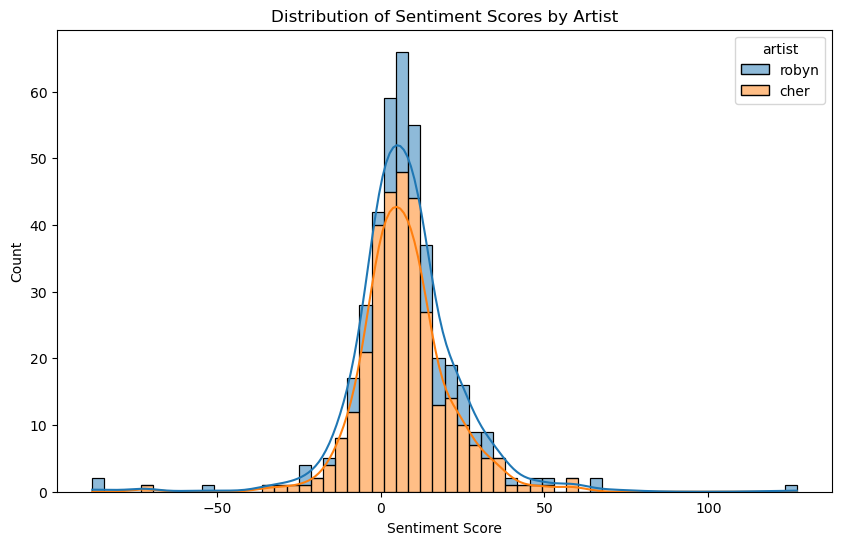

In [43]:
plt.figure(figsize=(10, 6))
sns.histplot(data=scored_lyrics_data, x='sentiment_score', hue='artist', multiple='stack', kde=True)
plt.title('Distribution of Sentiment Scores by Artist')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [63]:
# your code here

# defome positive and negative emojis with sentiment scores 
positive_emojis = ["😂", "❤️", "😍", "😊", "👍", "😁", "🔥", "🙏", "🎉", "🌟"]
negative_emojis = ["😭", "😔", "😒", "😩", "😑", "😴", "😠", "😖", "💔", "😢"]

positive_score = 1
negative_score = -1

# function to calculate sentiment based on emoji 
def calculate_sentiment(descriptions, positive_emojis, negative_emojis, positive_score, negative_score):
    total_score = 0
    count = 0
    
    for desc in descriptions:
        if isinstance(desc, str):
            has_positive = False
            has_negative = False
            for emoji in positive_emojis:
                if emoji in desc:
                    total_score += positive_score
                    has_positive = True
                    break  
            for emoji in negative_emojis:
                if emoji in desc:
                    total_score += negative_score
                    has_negative = True
                    break  
            if has_positive or has_negative:
                count += 1  
    
    if count > 0:
        average_sentiment = total_score / count
    else:
        average_sentiment = 0  
    
    return average_sentiment

In [64]:
results = {}
artists = twitter_data['artist'].unique()

for artist in artists:
    descriptions = twitter_data[twitter_data['artist'] == artist]['description'].fillna('').tolist()
    average_sentiment = calculate_sentiment(descriptions, positive_emojis, negative_emojis, positive_score, negative_score)
    results[artist] = average_sentiment

In [65]:
for artist, avg_sentiment in results.items():
    print(f"Artist: {artist}")
    print(f"Average Sentiment: {avg_sentiment:.2f}")
    print()
    
    #determine most popular negatiev and positive emoji
    most_popular_positive_emoji = max(data['emoji_counts'], key=lambda k: data['emoji_counts'][k] if k in positive_emojis else 0)
    most_popular_negative_emoji = max(data['emoji_counts'], key=lambda k: data['emoji_counts'][k] if k in negative_emojis else 0)
    
    print(f"Most Popular Positive Emoji: {most_popular_positive_emoji}")
    print(f"Most Popular Negative Emoji: {most_popular_negative_emoji}")
    print()

Artist: cher
Average Sentiment: 0.90

Most Popular Positive Emoji: ❤️
Most Popular Negative Emoji: 💔

Artist: robyn
Average Sentiment: 0.92

Most Popular Positive Emoji: ❤️
Most Popular Negative Emoji: 💔



Q: What is the average sentiment of your two artists? 

A: Average sentiment for Cher is 0.90, which is slightly lower than Robyn at 0.92. 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: Both Cher and Robyn's followers commonly use the ❤️ emoji as the most popular positive emoji and the 💔 emoji as the most popular negative emoji in their Twitter descriptions. This suggests a consistent emotional expression across both artist's fan bases on Twitter.
